# Chapter 2

In [1]:
from PIL import Image
from pylab import *
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import cv2 as cv
import os
import sys

## Import custom scripts

In [2]:
sys.path.insert(0, './src')
import imtools, harris

## Harris Corner Detector

The Harris corner detection algorithm (or sometimes the Harris & Stephens corner detector) is one of the simplest corner indicators available. The general idea is to locate interest points where the surrounding neighborhood shows edges in more than one direction; these are then image corners.

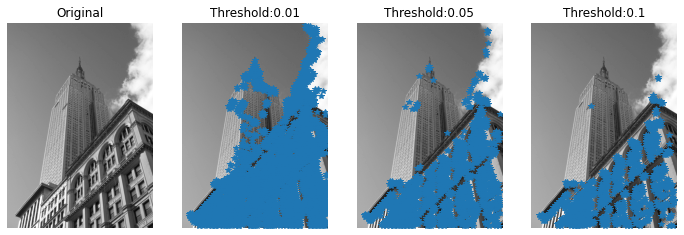

In [3]:
im = array(Image.open('images/empire.jpg').convert('L'))
harrisim = harris.compute_harris_response(im,sigma=3)

thres = [0.01, 0.05, 0.1]
fig, axs = plt.subplots(1, 4,figsize=(12,8))
gray()
axs[0].imshow(im)
axs[0].set_title('Original')
axs[0].axis('off')

for i in range(3):
    filtered_coords = harris.get_harris_points(harrisim,min_dist=6, threshold=thres[i])
    #harris.plot_harris_points(im, filtered_coords)
    axs[i+1].imshow(im)
    axs[i+1].plot([p[1] for p in filtered_coords], [p[0] for p in filtered_coords],'*')
    axs[i+1].set_title(f'Threshold:{thres[i]}')
    axs[i+1].axis('off')
plt.show()

Corner matching (find common corners from two f

starting matching


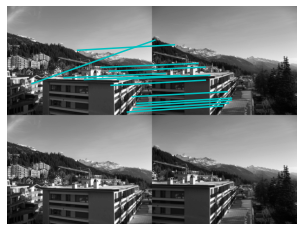

In [4]:
im1 = array(Image.open("images/crans_1_small.jpg").convert("L"))
im2 = array(Image.open("images/crans_2_small.jpg").convert("L"))

# resize to make matching faster
im1 = imtools.imresize(im1,(im1.shape[1]//2,im1.shape[0]//2))
im2 = imtools.imresize(im2,(im2.shape[1]//2,im2.shape[0]//2))

wid = 5
harrisim = harris.compute_harris_response(im1,5) 
filtered_coords1 = harris.get_harris_points(harrisim,wid+1) 
d1 = harris.get_descriptors(im1,filtered_coords1,wid)

harrisim = harris.compute_harris_response(im2,5) 
filtered_coords2 = harris.get_harris_points(harrisim,wid+1) 
d2 = harris.get_descriptors(im2,filtered_coords2,wid)

print('starting matching')
matches = harris.match_twosided(d1,d2)

figure()
gray() 
harris.plot_matches(im1, im2, filtered_coords1, filtered_coords2, matches[:100]) #first 100 matched corners
show()

## SIFT - Scale-Invariant Feature Transform (Better)

source: https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html

In [5]:
img = cv.imread("images/crans_1_small.jpg")
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.SIFT_create()

sift.detect() function finds the keypoint in the images. You can pass a mask if you want to search only a part of image. Each keypoint is a special structure which has many attributes like its (x,y) coordinates, size of the meaningful neighbourhood, angle which specifies its orientation, response that specifies strength of keypoints etc.

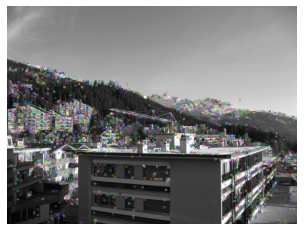

In [6]:
kp = sift.detect(gray, None)
img=cv.drawKeypoints(gray, kp, img)

plt.imshow(img)
plt.axis('off');

Draw circle on key point detected with size of the keypoints and the orientation

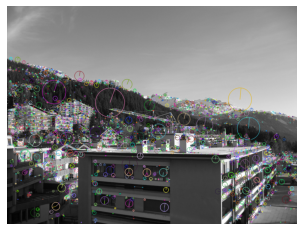

In [7]:
img=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.imshow(img)
plt.axis('off');

Calculate the descriptor:

In [8]:
sift = cv.SIFT_create()
kp, des = sift.detectAndCompute(gray,None)

`kp` will be a list of keypoints (cv2 keypoint type) and `des` is a numpy array of shape (number of keypoints) x 128

In [9]:
print(f"Length of kp: {len(kp)}.")
print(f"Shape of des: {des.shape}.")

Length of kp: 2940.
Shape of des: (2940, 128).


OR using ORB descriptors: https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html

In [14]:
img1 = cv.imread('images/crans_1_small.jpg',cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('images/crans_2_small.jpg',cv.IMREAD_GRAYSCALE) # trainImage

# Initiate ORB detector
orb = cv.ORB_create()

# find the keypoints and descriptors with ORB
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

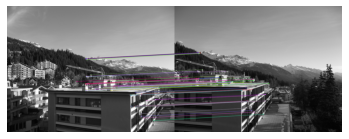

In [16]:
# create BFMatcher object
bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)

# Match descriptors.
matches = bf.match(des1,des2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv.drawMatches(img1, kp1, img2, kp2, matches[:100], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3)
plt.axis('off');

Sift:

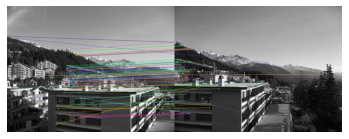

In [18]:
img1 = cv.imread('images/crans_1_small.jpg',cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('images/crans_2_small.jpg',cv.IMREAD_GRAYSCALE) # trainImage

# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

        # cv.drawMatchesKnn expects list of lists as matches.
img3 = cv.drawMatchesKnn(img1, kp1, img2, kp2, good[:100], None, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3)
plt.axis('off');

FLANN - Fast Library for Approximate Nearest Neighbors

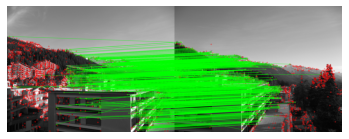

In [21]:
img1 = cv.imread('images/crans_1_small.jpg',cv.IMREAD_GRAYSCALE)          # queryImage
img2 = cv.imread('images/crans_2_small.jpg',cv.IMREAD_GRAYSCALE) # trainImage

# Initiate SIFT detector
sift = cv.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]
        
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)

img3 = cv.drawMatchesKnn(img1, kp1, img2, kp2, matches, None, **draw_params)

plt.imshow(img3)
plt.axis('off');

## Matching Geotagged Images

See section 2.3 on page 44